In [3]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os
import json
from pydantic import BaseModel

print("All imports successful")

All imports successful


In [4]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("API key loaded")

API key loaded


In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


In [6]:
class QualityScores(BaseModel):
    clarity: int
    completeness: int
    accuracy: int

print("QualityScores model defined")

QualityScores model defined


In [7]:
class ReflectionState(TypedDict):
    task: str
    draft: str
    critique: str
    iterations: int
    scores: QualityScores
    final_output: str

MAX_REFLECTIONS = 3
QUALITY_THRESHOLD = 4

print("ReflectionState with quality metrics defined")
print(f"MAX_REFLECTIONS: {MAX_REFLECTIONS}")
print(f"QUALITY_THRESHOLD: {QUALITY_THRESHOLD}")

ReflectionState with quality metrics defined
MAX_REFLECTIONS: 3
QUALITY_THRESHOLD: 4


In [8]:
def generator(state: ReflectionState) -> dict:
    if state["iterations"] == 0:
        prompt = f"Create a response for this task:\n\nTask: {state['task']}\n\nProvide a clear, complete answer."
        print("Generating initial draft")
    else:
        prompt = f"Improve this draft based on the critique:\n\nTask: {state['task']}\n\nCurrent draft: {state['draft']}\n\nCritique: {state['critique']}\n\nCreate an improved version."
        print(f"Refining draft, iteration {state['iterations']}")
    
    response = llm.invoke([HumanMessage(content=prompt)])
    print("Draft created")
    
    return {"draft": response.content}

print("Generator node defined")

Generator node defined


In [9]:
def critic(state: ReflectionState) -> dict:
    prompt = f"""Evaluate this response and provide scores (1-5) for each criteria:

Task: {state['task']}

Response: {state['draft']}

Score this response on:
1. Clarity: Is it clear and easy to understand?
2. Completeness: Does it fully address the task?
3. Accuracy: Is the information correct?

Return ONLY a JSON object with keys: clarity, completeness, accuracy and values as integers 1-5.

Example: {{"clarity": 3, "completeness": 4, "accuracy": 5}}"""
    
    print("Critiquing draft and scoring")
    response = llm.invoke([HumanMessage(content=prompt)])
    
    try:
        scores_data = json.loads(response.content.strip())
        scores = QualityScores(**scores_data)
    except Exception:
        print("Error parsing scores, using default scores")
        scores = QualityScores(clarity=3, completeness=3, accuracy=3)
    
    critique_prompt = f"""Based on these scores: Clarity={scores.clarity}, Completeness={scores.completeness}, Accuracy={scores.accuracy}

Provide constructive critique for improving the response."""
    
    critique_response = llm.invoke([HumanMessage(content=critique_prompt)])
    
    print(f"Scores - Clarity: {scores.clarity}, Completeness: {scores.completeness}, Accuracy: {scores.accuracy}")
    
    return {
        "critique": critique_response.content,
        "scores": scores,
        "iterations": state["iterations"] + 1
    }

print("Critic node with quality scoring defined")

Critic node with quality scoring defined


In [10]:
def reflection_finalizer(state: ReflectionState) -> dict:
    print("Reflection complete")
    return {"final_output": state["draft"]}

print("Finalizer node defined")

Finalizer node defined


In [11]:
def should_reflect_again(state: ReflectionState) -> Literal["generator", "finalizer"]:
    if state["iterations"] >= MAX_REFLECTIONS:
        print(f"Max iterations {MAX_REFLECTIONS} reached")
        return "finalizer"
    
    scores = state.get("scores")
    if scores:
        print(f"Checking scores against threshold {QUALITY_THRESHOLD}")
        print(f"Current scores: Clarity={scores.clarity}, Completeness={scores.completeness}, Accuracy={scores.accuracy}")
        if scores.clarity >= QUALITY_THRESHOLD and scores.completeness >= QUALITY_THRESHOLD and scores.accuracy >= QUALITY_THRESHOLD:
            print("All scores meet threshold")
            return "finalizer"
    
    print("Scores below threshold, continuing refinement")
    return "generator"

print("Routing function defined")

Routing function defined


In [13]:
reflection_builder = StateGraph(ReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic)
reflection_builder.add_node("finalizer", reflection_finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges(
    "critic",
    should_reflect_again,
    {"generator": "generator", "finalizer": "finalizer"}
)
reflection_builder.add_edge("finalizer", END)

reflection_agent = reflection_builder.compile()

print("Reflection agent with quality metrics created")

Reflection agent with quality metrics created


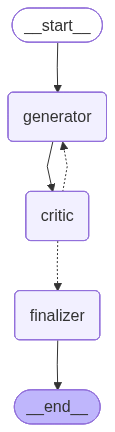

In [14]:
try:
    display(Image(reflection_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START -> generator -> critic -> (loop back to generator or go to finalizer) -> END")

In [15]:
result = reflection_agent.invoke({
    "task": "Explain what agentic patterns are and their importance in AI systems. Include examples of ReAct and Reflection patterns.",
    "draft": "",
    "critique": "",
    "iterations": 0,
    "scores": QualityScores(clarity=0, completeness=0, accuracy=0),
    "final_output": ""
})

print("=" * 70)
print("FINAL OUTPUT")
print("=" * 70)
print(result["final_output"])
print("=" * 70)
print(f"Total iterations: {result['iterations']}")
if "scores" in result:
    scores = result["scores"]
    print(f"Final scores - Clarity: {scores.clarity}, Completeness: {scores.completeness}, Accuracy: {scores.accuracy}")
print("=" * 70)

Generating initial draft
Draft created
Critiquing draft and scoring
Scores - Clarity: 5, Completeness: 5, Accuracy: 5
Checking scores against threshold 4
Current scores: Clarity=5, Completeness=5, Accuracy=5
All scores meet threshold
Reflection complete
FINAL OUTPUT
Agentic patterns refer to the behaviors and strategies that artificial intelligence (AI) systems employ to interact with their environment, make decisions, and achieve specific goals. These patterns are crucial for enabling AI systems to operate autonomously and effectively in complex, dynamic settings. By understanding and implementing agentic patterns, developers can create AI that not only processes information but also acts in a way that is purposeful and aligned with desired outcomes.

### Importance of Agentic Patterns in AI Systems

1. **Autonomy**: Agentic patterns allow AI systems to operate independently, making decisions without constant human intervention. This autonomy is essential for applications such as auto